# LightGBM for the Open University Learning Analytics Dataset (OULAD)

This is done for Research Question 2. The target is to predict if a student will pass or fail a course, using only the information available in the first half of the course duration.

Here, we are using the LightGBM algorithm and the goal is to have the highest possible AUC. For this, we use methods such as hyperparameter tuning and analyse if recursive feature elimination helps us to achieve our goal.

In [3]:
import pandas as pd # import the used libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier # use pip install lightgbm command to install the library
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE

Read the data created by Q2_Final_dataset_dev.ipynb.

In [4]:
data_encoded = pd.read_csv('../Q2TransitionFolder/Q2_data_encoded.csv')
print(data_encoded.shape)
data_encoded.head(5)

(23661, 17)


,gender,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,sum_click,consistency,TMA_average,CMA_average,TMA_score,CMA_score,Total_average_score,Total_assessment_score,submission_date_average
0,1,3,9.0,2.0,0,240,0,1,710.0,16.754419,81.000000,0.0,4080.0,0.0,81.000000,4080.0,-1.333333
1,0,3,2.0,1.0,0,60,0,1,986.0,15.279285,69.333333,0.0,3460.0,0.0,69.333333,3460.0,1.666667
2,0,2,5.0,1.0,0,60,0,1,1382.0,14.551545,72.333333,0.0,3620.0,0.0,72.333333,3620.0,-2.333333
3,0,1,5.0,0.0,0,60,0,1,799.0,13.276953,54.000000,0.0,2550.0,0.0,54.000000,2550.0,11.666667
4,1,2,8.0,1.0,0,60,0,1,1312.0,15.250278,74.000000,0.0,3650.0,0.0,74.000000,3650.0,3.333333


In [5]:
# Separate the target variable, which is 'final_result' from the rest of the independent variables.
X = data_encoded.drop(columns=['final_result'])
y = data_encoded['final_result']

# we choose a random state to have deterministic results
RANDOM_STATE = 42

# Split the data into training and test sets, where 70% is used for training and 30% for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

This is the hyperparameter tuning part for LightGBM


In [ ]:
# Initialize classifier with no hyperparameters
clf = LGBMClassifier(random_state=RANDOM_STATE)

# Define the parameter grid for grid search.
param_grid = {
    'num_leaves': [31, 127],
    'max_depth': [5, 7, 9, -1],
    'min_data_in_leaf': [30, 40, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000]
}

# We define cross-validation, using stratified k-fold, to ensure proportions.
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Initialise the grid search, targeting to increase the ROC-AUC metric.
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=2)

# Testing the combinations of hyperparameters
grid_search.fit(X, y)

# Print the best parameters determined by the grid search
print(grid_search.best_params_)

# Current best set: 
# {'learning_rate': 0.01, 'max_depth': 7, 'min_data_in_leaf': 40, 'n_estimators': 500, 'num_leaves': 127}

Fitting 3 folds for each of 216 candidates, totalling 648 fits


In [14]:
# Initialize our classifier using the hyperparameters obtained earlier
clf = LGBMClassifier(learning_rate = 0.01, max_depth =  7, min_data_in_leaf = 40, n_estimators = 500, num_leaves = 127,random_state=RANDOM_STATE, verbose=-1)

# Fit the model on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
print(f"ROC AUC: {roc_auc}")

# Print detailed classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.8234962670798704
F1 Score: 0.864202882843828
ROC AUC: 0.887261131378352
              precision    recall  f1-score   support

           0       0.82      0.69      0.75      2702
           1       0.83      0.91      0.86      4397

    accuracy                           0.82      7099
   macro avg       0.82      0.80      0.81      7099
weighted avg       0.82      0.82      0.82      7099



In [ ]:
best_roc_auc = 0
best_num_features = 0
best_feature_set = None # To store the best set of features
all_roc_aucs = [] # List to store all ROC AUCs

for i in range(1, 17):
   # Initialize the Recursive Feature Elimination 
    rfe = RFE(estimator=LGBMClassifier(learning_rate = 0.01, max_depth =  7, min_data_in_leaf = 40, n_estimators =  500, num_leaves=  127,  random_state=RANDOM_STATE, verbose=-1), n_features_to_select=i)

    # Fit RFE on the training data
    rfe.fit(X_train, y_train)

    # Predict probability scores for the test set
    y_pred_proba_rfe = rfe.predict_proba(X_test)[:, 1]

    # Calculate the ROC AUC score for the predictions
    roc_auc = roc_auc_score(y_test, y_pred_proba_rfe)
    all_roc_aucs.append(roc_auc)

    # If the current ROC AUC score is better than our best, update our best metrics
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_num_features = i
        best_feature_set = [col for col, selected in zip(X_train.columns, rfe.support_) if selected]

# Results
print(f"Best number of features: {best_num_features} with ROC AUC: {best_roc_auc}")
print(f"Best feature set: {best_feature_set}")

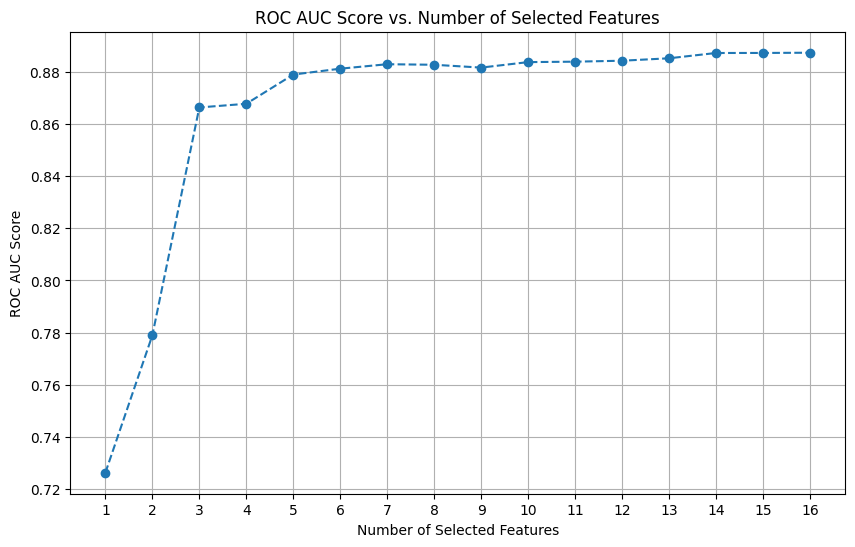

In [13]:
# Visualization of the stages values for RFE
plt.figure(figsize=(10, 6))
plt.plot(range(1, 17), all_roc_aucs, marker='o', linestyle='--')
plt.title('ROC AUC Score vs. Number of Selected Features')
plt.xlabel('Number of Selected Features')
plt.ylabel('ROC AUC Score')
plt.xticks(np.arange(1, 17, 1))
plt.grid(True)
plt.show()